# Predator Prey Simulation (Wolves and Rabbits)



In [1]:
%matplotlib inline  

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import math as math

What follows is a predator prey model, in which wolves hunt rabbits on a grid.


The first function returns true if there is a rabbit at that point in space and time, and false otherwise. This will be used to let predators detect the rabbits.

In [2]:
def Rabbit(x,y,t,rabbit):
    out = 0
    if (x,y,t) in rabbit:
           out = True
    else:
           out = False
    return out

The next codes will generate the wolf function in a similar fashion. Each wolf will have a string s, defined later, it is effectively a string of "genes" for each wolf. It will be unique and can thus serve as an identifier for each wolf.

In [3]:
def Wolf(x,y,t,wolf):
    out = 0
    if (x,y,t) in wolf:
           out = True
    else:
           out = False
    return out

The following cell will define the wolves' vision. The wolf can see in a circle 10 units around itself, outputting lists of nearby wolves and rabbits. Note the wolf does not "see" itself.

In [4]:
def wolf_see(x,y,wolf,rabbit):
    near_rab =[]
    near_wolf =[]
    for r in rabbit:
        norm = (x-r[0])**2 + (x-r[1])**2
        if norm <= 100:
            near_rab.append(r)
    for w in wolf:
        norm = (x-w[0])**2 + (x-w[1])**2
        if 1 < norm <= 100:
            near_wolf.append(w)
    return near_rab,near_wolf
    

Note that this function actually applies on any point in space, you don't need a wolf in a point (x,y) to call it. It will have as inputs the position of a known wolf though.

As of yet, there is no motion in the world. 

Next, we will add functions that move the wolves around. 

To do this, new position lists will be created using a time of t+1 i.e. increment the time-step and move the wolves. This movement will be based on a potential function. Esentially, wolves will repel eachother at close ranges, and attract at long ranges (in the wolf's vision). The same applies for rabbits. The string s of each wolf will be used to determine the coefficients of the potential function. The potential used will be similar to a Leonard-Jones potential.

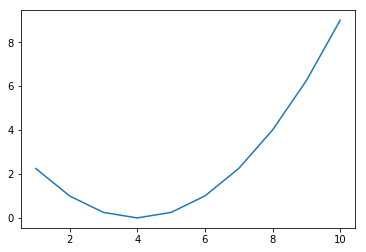

In [5]:
def w_potential(a,b,c,x):
    y = a +b*x+c*(x**2)
    return y

x_lis=[i for i in range(1,11)]
y_lis =[w_potential(4,-2,0.25,x) for x in x_lis]


plt.plot(x_lis,y_lis)


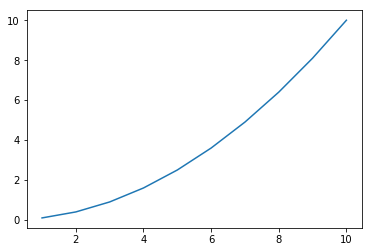

In [6]:
def r_potential(d,e,x):
    y = e*(x**2)+d
    return y

x_lis=[i for i in range(1,11)]
y_lis =[r_potential(0,0.1,x) for x in x_lis]


plt.plot(x_lis,y_lis)

Remembering that the gene string s uniquely identifies each wolf, we will add some parameters for each wolf associated with this string. The string will be of the form "aXXXXbXXXXcXXXXdXXXXeXXXXnXX",where a,b,c,d,e are parameters in the potentials and n can be used to distinguish wolves. The X values indicate either integers,signs, or a decimal point. 

The function w_move generates a movement vector for the wolf. The gene string generates the potential function, and the potential function is multiplied by the vector pointing to the object of the potential (i.e wolf or rabbit). The potentials are then summed, resulting in a vector pointing to the wolf's next location. The vector is normed to a unit of two (the arguments will then be converted to int in the next function, which adds a time step). The function reaches a very high value for positions greater than 100 or less than 0, to confine the wolves.

In [7]:
def w_move(w,wolf,rabbit):
    sm = wolf[w]
    a = float(sm[1:5])
    b = float(sm[6:10])
    c = float(sm[11:15])
    d = float(sm[16:20])
    e =float(sm[21:25])
    rab,wuf = wolf_see(w[0],w[1],wolf,rabbit)
    u_current = 0
    for wi in wolf:
        norm = np.sqrt(float((w[0]-wi[0])**2 + (w[1]-wi[1])**2))
        mult = w_potential(a,b,c,norm)
        u_current += mult
    for r in rabbit:
        norm = np.sqrt(float((w[0]-r[0])**2 + (w[1]-r[1])**2))
        mult = r_potential(d,e,norm)
        u_current += mult
    choices = [-1,0,1]
    next_w = {}
    next_w[(w[0],w[1])] = u_current
    for i in choices:
        for j in choices:
            u_next =0
            w_i = w[0]+i
            w_j = w[1] +j
            if (w_i < 0 or w_j <0 or w_i >100 or w_j >100):
                u_next = 999999
            else:
                v_nex = (w_i,w_j)
                for wi in wolf:
                    norm = np.sqrt(float((w_i-wi[0])**2 + (w_j-wi[1])**2))
                    mult = w_potential(a,b,c,norm)
                    u_next+= mult
                for r in rabbit:
                    norm = np.sqrt(float((w_i-r[0])**2 + (w_i-r[1])**2))
                    mult = r_potential(d,e,norm)
                    u_next += mult
            if u_next <= u_current:
                next_w[v_nex] = u_next
    out = min(next_w, key=next_w.get)
    return out
    
        
wolf = {(10,10,0):"a2.00b-0.5c0.05d-15.e0.15nXX",(15,15,0):"a2.00b-0.05c0.05dXXXXeXXXXnX1"}
rabbit ={(5,5,0):"1"}
e_list = {}

w_move((10,10,0),wolf,rabbit)

(9, 11)

One additional parameter will be energy. It will be found in a dictionary that associates a gene string with an energy value and pregnancy value (used later for generating more wolves). When their postions are equal, the rabbit will be deleted and the wolf's energy increased. That is, the wolf ate the rabbit. Moving will reduce the wolf's energy by the number of tiles moved (max 2). Rabbit motion will be added later. 

The next function will be the (first) time step function. It increments time by a step, generating new dictionaries from the previous ones(rabbit,wolf,e_list). e_list is the list of energies for each wolf. When e hits 0, the wolf is deleted.


In [8]:
def time_step_0(wolf,rabbit,e_list):
    new_wolf ={}
    new_rab = {}
    new_e ={}
    for w in wolf:
        s = wolf[w]
        t = w[2]
        e = e_list[s]
        step = w_move(w,wolf,rabbit)
        x = step[0]
        y = step[1]
        t +=  1
        w1 = (x,y,t)
        if w1 in new_wolf:
            e -= 1
            w1 = w
        e -= 1+abs(w[0]-step[0]) + abs(w[1]-step[1])
        if e <= 0:
            print("Wolf died") 
        else:
            new_e[s] = e
            new_wolf[w1] = s
    for r in rabbit:
        s = rabbit[r]
        x = r[0]
        y = r[1]
        t = r[2]
        t += 1
        r1 = (x,y,t)
        if r1 in new_wolf:
            sw = new_wolf[r1]
            new_e[sw] = 500
            print("Wolf ate rabbit")
        else:
            new_rab[r1] = s
    
    return new_wolf,new_rab,new_e
            
        

Now to test the code.

Wolf ate rabbit
Wolf ate rabbit


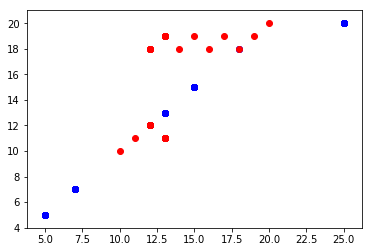

In [9]:
wolf_init  = {(10,10,0):"a4.00b-4.0c0.25d-15.e0.17n01",(20,20,0):"a4.00b-4.0c0.25d-15.e0.17n02"}

t = list(wolf_init.keys())[0][2]

rab_init ={(12,12,0):"1",(13,13,0):"2",(18,18,0):"3",(15,15,0):"4",(5,5,0):"5", (7,7,0):"6", (25,20,0):"7"}
e_init = {"a4.00b-4.0c0.25d-15.e0.17n01":500,"a4.00b-4.0c0.25d-15.e0.17n02":500}

for t in range(0,20):
    for w in wolf_init:
        plt.scatter(w[0],w[1], c= 'r')
    for r in rab_init:
        plt.scatter(r[0],r[1], c= 'b')
    wolf_init,rab_init,e_init = time_step_0(wolf_init,rab_init,e_init)
    t = list(wolf_init.keys())[0][2]


While it is somewhat hard to tell from the above plot, the lower wolf got trapped in a minimum of potential energy. There are a few ways to remedy this. One would be to add a jitter, that can push the wolf out of the minima; for example, by deleting a single parameter from the "wolf_see" list to change the local potential.

Another way, which will also progress the simulation, is to make the rabbit's positions adapt to the wolf's prescense. Then the minima will be broken in the next time step. The next function will be the sight function for the rabbit, its potential and its step function. It has worse vision, but will be able to move faster.

In [10]:
def r_see(x,y,wolf):
    near_wolf =[]
    for w in wolf:
        norm = (x-w[0])**2 + (x-w[1])**2
        if 1 < norm <= 25:
            near_wolf.append(w)
    return near_wolf

Next the potential:

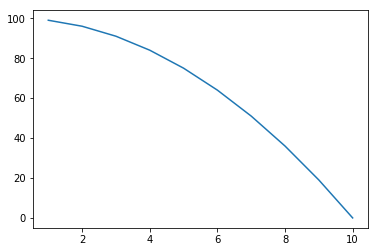

In [11]:
def rab_potential(x):
    y = 100 -(x**2)
    return y

x_lis=[i for i in range(1,11)]
y_lis =[rab_potential(x) for x in x_lis]


plt.plot(x_lis,y_lis)

The rabbit will run almost constantly when a wolf is in sight. Next, the movement function for rabbits:

In [12]:
def r_move(r,wolf):
    wuf= r_see(w[0],w[1],wolf)
    u_current = 0
    for wi in wuf:
        norm = np.sqrt(float((r[0]-wi[0])**2 + (r[1]-wi[1])**2))
        mult = rab_potential(norm)
        u_current += mult
    choices = [-1,0,1]
    next_r = {}
    next_r[(r[0],r[1])] = u_current
    for i in choices:
        for j in choices:
            u_next =0
            r_i = r[0]+i
            r_j = r[1] +j
            if (r_i < 0 or r_j <0 or r_i >100 or r_j >100):
                u_next = 999999
            else:
                v_nex = (r_i,r_j)
                for wi in wolf:
                    norm = np.sqrt(float((r_i-wi[0])**2 + (r_j-wi[1])**2))
                    mult = rab_potential(norm)
                    u_next+= mult
            if u_next <= u_current:
                next_r[v_nex] = u_next
    out = min(next_r, key=next_r.get)
    return out
    

Lastly, the rabbits time step movement function. It is a modifcation of the previous function, adding rabbit movement. Wolves move before rabbits. It will handle the self-avoidance between rabbits, preventing them from overlapping with eachother. Since they can graze, they don't lose energy. The new function will also fix a small bug with timesteps.

In [13]:
def time_step_1(wolf,rabbit,e_list):
    new_wolf ={}
    new_rab = {}
    new_e ={}
    for w in wolf:
        s = wolf[w]
        t = w[2]
        e = e_list[s]
        step = w_move(w,wolf,rabbit)
        x = step[0]
        y = step[1]
        t +=  1
        w1 = (x,y,t)
        w2 = (w[0],w[1],t)
        if w1 in new_wolf:
            e -= 1
            w1 = w2
        e -= 1+abs(w[0]-step[0]) + abs(w[1]-step[1])
        if e <= 0:
            print("Wolf died") 
        else:
            new_e[s] = e
            new_wolf[w1] = s
    for r in rabbit:
        s = rabbit[r]
        t = r[2]
        step = r_move(r,rabbit)
        x = step[0]
        y = step[1]
        t +=  1
        r1 = (x,y,t)
        r2 = (r[0],r[1],t)
        if r1 in new_rab:
            r1 = r2
        if r1 in new_wolf:
            sw = new_wolf[r1]
            new_e[sw] += 50
            print("Wolf ate rabbit")
        else:
            new_rab[r1] = s
    
    return new_wolf,new_rab,new_e
            
        

Now, to test the new code:

Wolf ate rabbit
Wolf ate rabbit


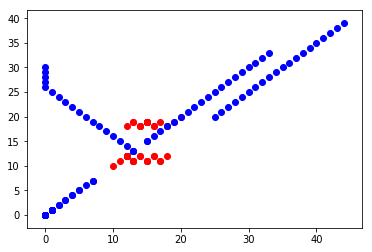

In [14]:
wolf_init  = {(10,10,0):"a4.00b-4.0c0.25d-15.e0.17n01",(20,20,0):"a4.00b-4.0c0.25d-15.e0.17n02"}

t = list(wolf_init.keys())[0][2]

rab_init ={(12,12,0):"1",(13,13,0):"2",(18,18,0):"3",(15,15,0):"4",(5,5,0):"5", (7,7,0):"6", (25,20,0):"7"}
e_init = {"a4.00b-4.0c0.25d-15.e0.17n01":1000,"a4.00b-4.0c0.25d-15.e0.17n02":1000}

for t in range(0,20):
    for r in rab_init:
        plt.scatter(r[0],r[1], c= 'b')
    for w in wolf_init:
        plt.scatter(w[0],w[1], c= 'r')
    wolf_init,rab_init,e_init = time_step_1(wolf_init,rab_init,e_init)
    t = list(wolf_init.keys())[0][2]

The code seems to be working correctly, but the wolves can only catch a few rabbits before the other rabbits have run away. This code was intended to be a genetic algorithim of sorts, that is, the wolves would adapt to become more efficient hunters.

What's a requirement for adaption? Genetic variation! We're going to add i) more wolves, ii) even more rabbits (1:10 ratio), iii) and add some random variation to the wolves DNA strings. To do that, we'll utilize the wolf_gen function, and the rabbit_gen function. The potential function parameters used before will be the baseline for each wolf. They are reasonable in structure, and will optimize as less fit wolves die. The strings to input into wolf_gen will be are the parent strings for reproduction later on, for now, just note the empty string will produce the default s.

In [15]:
def Wolf_gen(x,y,t,wolf,e_list,s1,s2):
    n = len(wolf)
    point = (x,y,t)
    while(point in wolf):
        point = (x+1,y+1,t)
    if (s1 == "" or s2 == ""):
        s0 = "a4.00b-4.0c0.25d-15.e0.17n" + str(n)
        s = ""
        i_prev = -1
        mod_list = {1,3,4,7,9,11,13,14,17,18,21,23,24} #These are the positions of the characters to modify in the above string
        for i in mod_list:
            rs = np.random.randint(0,9)
            s += s0[i_prev+1:i] +str(rs)
            if (i == 24):
                s += s[i+1:len(s)]
            i_prev = i
        e_list[s] = 500
    else:
        coin = np.random.randint(0, 2)
        if coin == 1:
            s = s1[0:12] + s2[13:25]+str(n)
        if coin == 0:
            s = s2[0:12] + s1[13:25]+str(n)
        e_list[s1] -= 100
        e_list[s2] -= 100
        e_list[s] = 200
    wolf[point] = s
    return wolf

def Rabbit_gen(x,y,t,rabbit):
    n = len(rabbit)
    point = (x,y,t)
    while(point in rabbit):
        point = (x+1,y+1,t)
    rabbit[point] = str(n)
    return rabbit


Now for a test of this code. Wolves will be placed on the axes, surrounding a center filled with rabbits.

Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit
Wolf ate rabbit


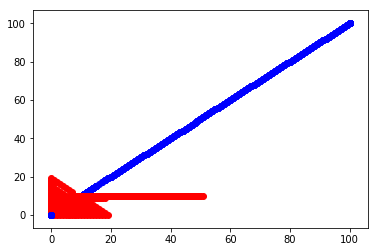

In [16]:
wolfs ={}
e_s = {}
rabbs = {}


for i in range(0,20):
    Wolf_gen(i,0,0,wolfs,e_s,"","")
    Wolf_gen(0,i,0,wolfs,e_s,"","")
    Rabbit_gen(i+1,i+1,0,rabbs)
    
t = list(wolf_init.keys())[0][2]   
    
for t in range(0,100):
    for r in rabbs:
        plt.scatter(r[0],r[1], c= 'b')
    for w in wolfs:
        plt.scatter(w[0],w[1], c= 'r')
    wolfs,rabbs,e_s = time_step_1(wolfs,rabbs,e_s)
    t = list(wolfs.keys())[0][2]

## To do

*Add more comments for clarity

*Add reproduction function to produce more rabbits and wolves
    *Costs time step and energy, so costly (maybe add more potentials?)

*Animate

*Long run for evolution of wolf hunting behavior